EDA 

# Импорт необходимых модулей и чтение датасета

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

https://zindi.africa/competitions/datadrive2030-early-learning-predictors-challenge

Задача: Использовать методы машинного обучения для выявления факторов в программах раннего обучения, которые способствуют улучшению результатов обучения у детей. При прогнозировании оценки ELOM ребенка и 15 наиболее важных переменных для каждого ребенка.

Целевая функция - target

Данные:
Были сопоставлены данные из нескольких программ и проектов, которые использовали инструменты ELOM, за период 2019-2022 годов:

- PQA: оценка качества учебной программы ELOM

- PRA: Интервью с практикующим (teacher interview)

- PRI: Основное интервью

- OBS: Сохранение окружающей среды

Каждый из них является разными источниками данных. Отдельное описание каждого столбца можно посмотреть в VariableDescription

Метрика - RMSE


In [2]:
df_test = pd.read_csv('Test.csv')
df_train = pd.read_csv('Train.csv')
VariableDescription = pd.read_csv('VariableDescription.csv')
SampleSubmission = pd.read_csv('SampleSubmission.csv')

In [3]:
VariableDescription.head()

,Variable Name,Variable Label,Answer Label
0,child_id,Unique child ID,Open ended
1,data_year,Year data was collected,Open ended
2,child_date,ELOM date,Open ended
3,child_age,Child age in months,Open ended
4,child_enrolment_date,Date enrolled in ELP,Open ended


Окончательный объединенный набор данных состоял из 12 265 детей в 2 217 учреждениях

In [4]:
df_train.shape, df_test.shape

((8585, 679), (3680, 678))

# % пропусков

In [5]:
df_train.head()

,child_id,data_year,child_date,child_age,child_enrolment_date,child_months_enrolment,child_grant,child_years_in_programme,child_height,child_observe_attentive,...,obs_cooking_5,obs_cooking_6,obs_heating_1,obs_heating_2,obs_heating_3,obs_heating_4,obs_heating_5,obs_heating_6,obs_heating_7,target
0,ID_SYSJ2FM0D,2022.0,2022-02-03,59.000000,NaN,NaN,NaN,NaN,NaN,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
1,ID_J5BTFOZR3,2019.0,NaN,60.163933,NaN,NaN,NaN,1st year in the programme,103.000000,Sometimes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.869999
2,ID_R00SN7AUD,2022.0,2022-03-11,69.000000,NaN,NaN,NaN,NaN,108.400002,Often,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.520000
3,ID_BSSK60PAZ,2021.0,2021-10-13,53.000000,2020-01-15,20.0,No,1st year in the programme,98.099998,Almost always,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.599998
4,ID_IZTY6TC4D,2021.0,2021-10-13,57.000000,2021-10-13,0.0,NaN,2nd year in programme,114.000000,Almost always,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,76.599998


In [6]:
cols_less30Nan = []
cols_less40Nan = []
cols_less50Nan = []
cols_less70Nan = []
cols_more70Nan = []

for col in df_train.drop(columns=['target']).columns:
    if df_train[col].isnull().sum() / df_train.shape[0] < 0.3:
        cols_less30Nan.append(col)
    elif df_train[col].isnull().sum() / df_train.shape[0] < 0.4:
        cols_less40Nan.append(col)
    elif df_train[col].isnull().sum() / df_train.shape[0] < 0.5:
        cols_less50Nan.append(col)
    elif df_train[col].isnull().sum() / df_train.shape[0] < 0.7:
        cols_less70Nan.append(col)
    else:
        cols_more70Nan.append(col)

print('Всего ' + str(len(cols_less30Nan)) + ' признаков с менее 30% пропусков')
print('Всего ' + str(len(cols_less40Nan)) + ' признаков с менее 40% пропусков')
print('Всего ' + str(len(cols_less50Nan)) + ' признаков с менее 50% пропусков')
print('Всего ' + str(len(cols_less70Nan)) + ' признаков с менее 70% пропусков')
print('Всего ' + str(len(cols_more70Nan)) + ' признаков с более 70% пропусков')

# Создаю список, в который в дальнейшем буду добавлять колонки для удаления
drop_cols = cols_more70Nan

Всего 48 признаков с менее 30% пропусков
Всего 92 признаков с менее 40% пропусков
Всего 107 признаков с менее 50% пропусков
Всего 30 признаков с менее 70% пропусков
Всего 401 признаков с более 70% пропусков


In [7]:
df_train['%_NaN'] = round(df_train.isna().sum(1) / (df_train.shape[1] - 1) * 100)
df_test['%_NaN'] = round(df_test.isna().sum(1) / df_test.shape[1] * 100)

In [8]:
df_train['%_NaN'].describe()

count    8585.000000
mean       64.839604
std        28.362013
min        10.000000
25%        60.000000
50%        63.000000
75%        93.000000
max        97.000000
Name: %_NaN, dtype: float64

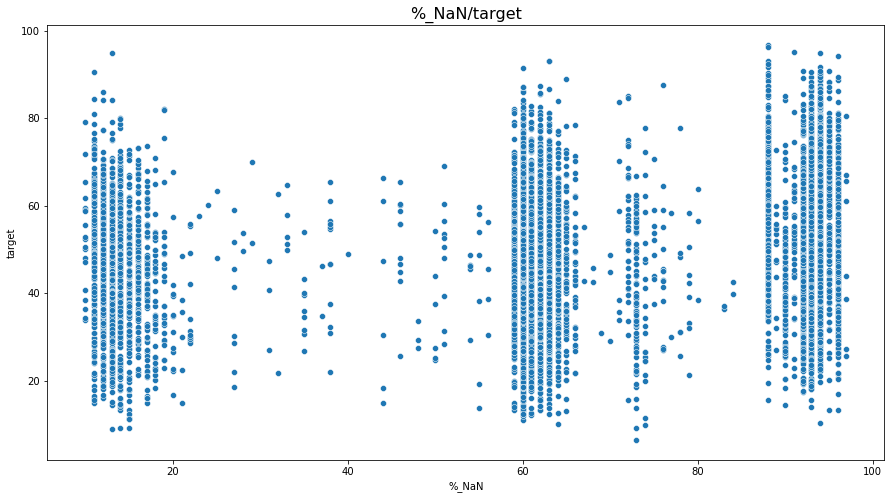

In [9]:
plt.figure(figsize=(15,8))

sns.scatterplot(
    x="%_NaN",
    y="target",
    data=df_train)

plt.title('%_NaN/target', fontsize=16)
plt.show()

Можно увидеть 3 основные группы по % пропусков

# Гипотезы

In [10]:
def map_rang(cols:list, dct, df_lst=[df_train, df_test]) -> None:
    # выражаем ранговые категориальные данные в цифровых значениях
    for df in df_lst:
        for col in cols:
            df[col] = df[col].map(dct)


def boxplot(cols:list, y="target", df=df_train, hue=None) -> None:
    # boxplot по колонкам относительно target
    for col in cols:
        plt.figure(figsize=(15, 5))

        sns.boxplot(x=col, y=y, hue=hue, data=df)

        plt.ylabel(y, fontsize=14)
        plt.xlabel(col, fontsize=14)
        plt.title(y + '/' + col, fontsize=16)
        plt.show()

## Гипотеза 1

с увеличением % пропусков - увеличивается таргет. Возможно это могло бы быть связано с тем, что детям с более низким таргетом требуется больше внимания

In [11]:
bins = [-1, 40, 80, 101]
bin_labels = ["less 40% Nans", "less 80% Nans", "more 80% Nans"]

df_train['NaN_bins'] = pd.cut(df_train['%_NaN'], bins=bins, labels=bin_labels).astype(object)
df_test['NaN_bins'] = pd.cut(df_test['%_NaN'], bins=bins, labels=bin_labels).astype(object)

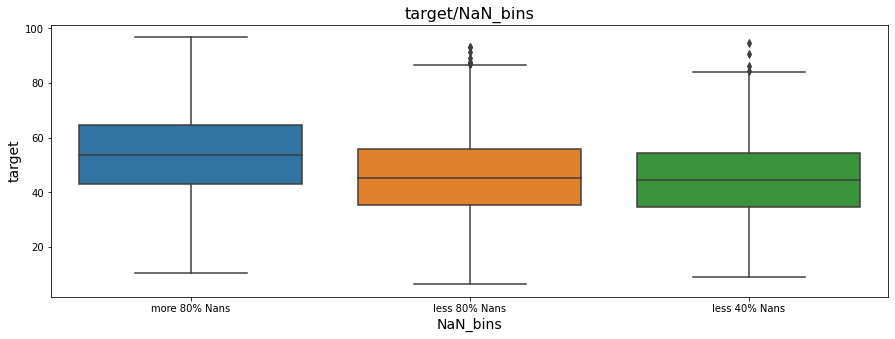

In [12]:
boxplot(['NaN_bins'])

Вывод: гипотеза подтвердилась. Пропуски стоит заполнять новыми значениями

В датасете очень много признаков, много пропусков. Их стоит максимально сгруппировать

## Гипотеза 2

Чем дольше ребенок состит в программе, тем выше таргет

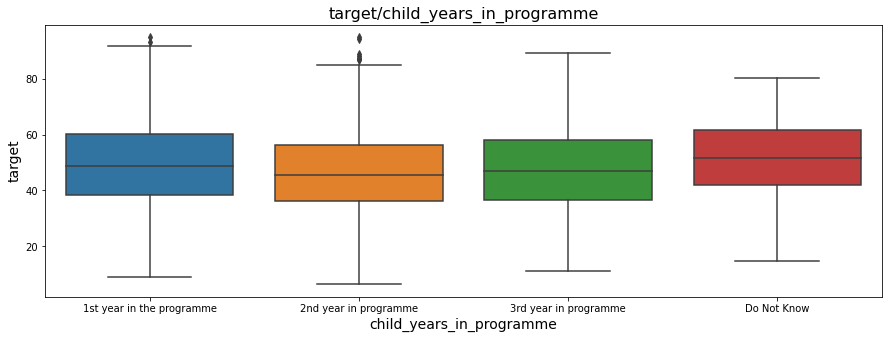

In [13]:
boxplot(['child_years_in_programme'])

Когда неизвестно, состоит ли ребенок в программе, таргет немного выше. Немного ниже таргет при 2 года в программе

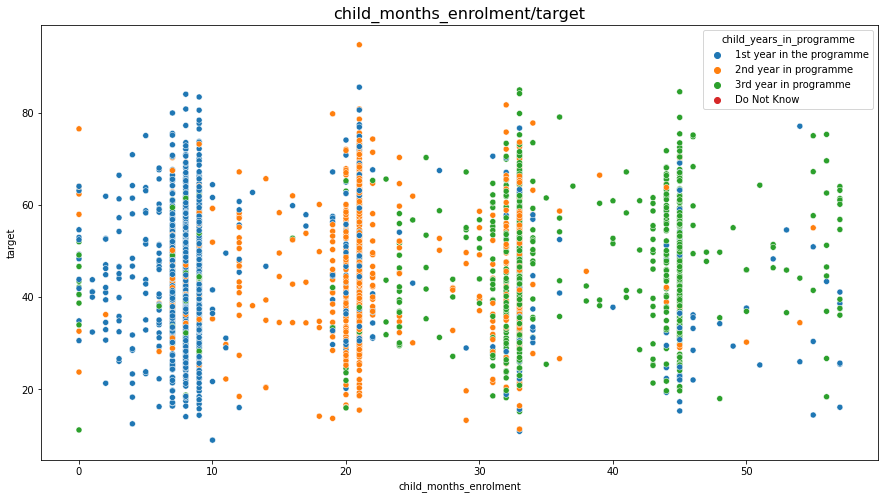

In [14]:
plt.figure(figsize=(15,8))

sns.scatterplot(
    x="child_months_enrolment",
    y="target",
    hue="child_years_in_programme",
    data=df_train)

plt.title('child_months_enrolment/target', fontsize=16)
plt.show()

Иногда число месяцев в программе не совпадает с числом лет

In [15]:
# все категорильные колонки, которые можно перевести в ранг - буду переводить
map_rang(["child_years_in_programme"], {
    'Do Not Know': 0,
    '1st year in the programme': 1, 
    '2nd year in programme': 2,
    '3rd year in programme': 3})

## Гипотеза 3

Чем старше ребенок - тем выше таргет. У девочек таргет выше

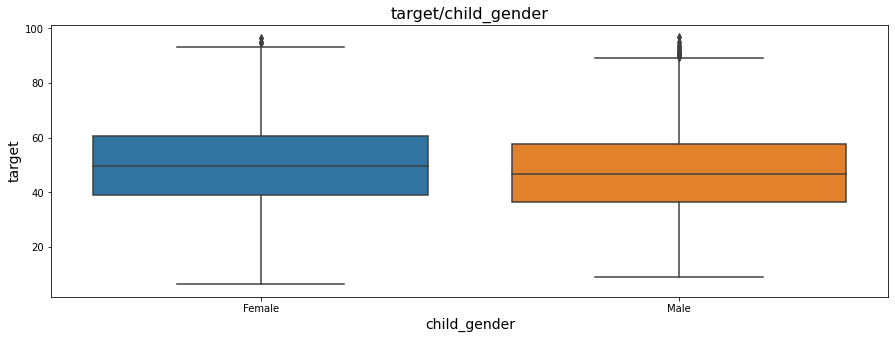

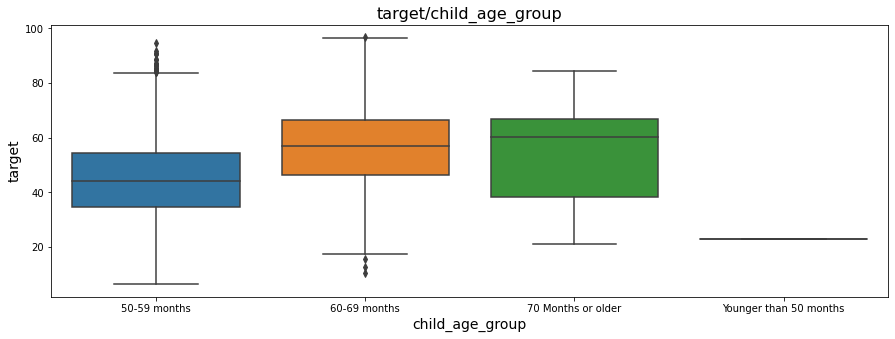

In [16]:
boxplot(['child_gender', 'child_age_group'])

У девочек немного выше таргет, чем старше ребенок - тем выше таргет

In [17]:
df_train.child_age.describe()

count    8585.000000
mean       58.116873
std         5.318927
min        49.475410
25%        54.000000
50%        57.000000
75%        62.032787
max        69.683777
Name: child_age, dtype: float64

В целом нет детей старше 70 месяцев и очень мало младше 50

In [18]:
map_rang(['child_age_group'],{
    'Younger than 50 months':0,
    '50-59 months':1,
    '60-69 months':2,
    '70 Months or older':3
})

## Гипотеза 4

Месяц рождения ребенка влияет на таргет

In [19]:
# заполним пропуски в точной дате как с начала года, изменяем тип данных на дату
df_train.child_date.fillna(df_train['data_year'].astype("int")
                          .astype("string") + '-01-01', inplace=True)
df_test.child_date.fillna(df_test['data_year'].astype("int")
                          .astype("string") + '-01-01', inplace=True)

df_train['child_date'] = pd.to_datetime(df_train['child_date'])
df_test['child_date'] = pd.to_datetime(df_test['child_date'])

# колонка child_enrolment_date полностью коррелирует по пропускам с child_months_enrolment, оставим только её
drop_cols += ['child_enrolment_date']

In [20]:
from dateutil.relativedelta import relativedelta

def fillna_child_dob(child_dob:str, child_date:str, child_age:int) -> str:
    # заполняет пропуски в месяце рождения ребенка
    if len(str(child_dob)) < 5:
        child_dob = child_date - relativedelta(months=int(child_age))
    return child_dob

In [21]:
df_train['child_dob'] = df_train.apply(lambda x: fillna_child_dob(
    x['child_dob'], x['child_date'], x['child_age']),axis=1)
df_test['child_dob'] = df_test.apply(lambda x: fillna_child_dob(
    x['child_dob'], x['child_date'], x['child_age']),axis=1)

df_train['child_birth_month'] = df_train['child_dob'].astype('datetime64').dt.month_name()
df_test['child_birth_month'] = df_test['child_dob'].astype('datetime64').dt.month_name()

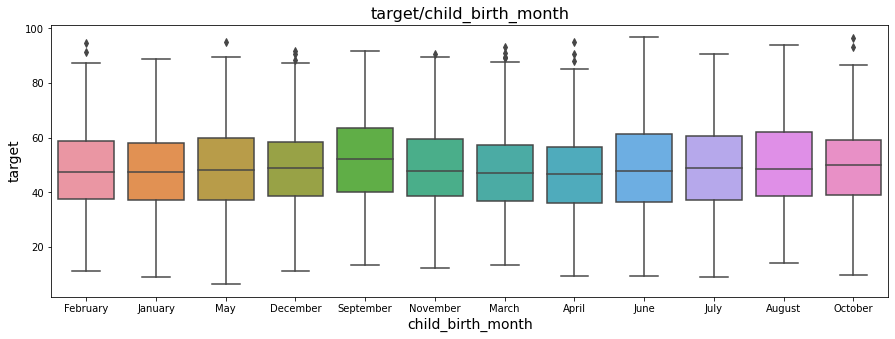

In [22]:
boxplot(['child_birth_month'])

Вывод: месяц рождения ребенка не оказывает значительного влияния на таргет

In [23]:
drop_cols += ['child_dob', 'child_date']

## Гипотеза 5

Чем выше оценка ребенка - тем выше таргет

In [24]:
df_train[["child_observe_attentive", "child_observe_concentrated", 
          "child_observe_diligent", "child_observe_interested",
          "child_observe_total"]].head()

,child_observe_attentive,child_observe_concentrated,child_observe_diligent,child_observe_interested,child_observe_total
0,Sometimes,Sometimes,Sometimes,Sometimes,4.0
1,Sometimes,Almost never,Sometimes,Often,4.0
2,Often,Often,Sometimes,Often,7.0
3,Almost always,Almost always,Sometimes,Often,9.0
4,Almost always,Almost always,Almost always,Almost always,12.0


In [25]:
observe_cols = ["child_observe_attentive", "child_observe_concentrated", 
          "child_observe_diligent", "child_observe_interested"]

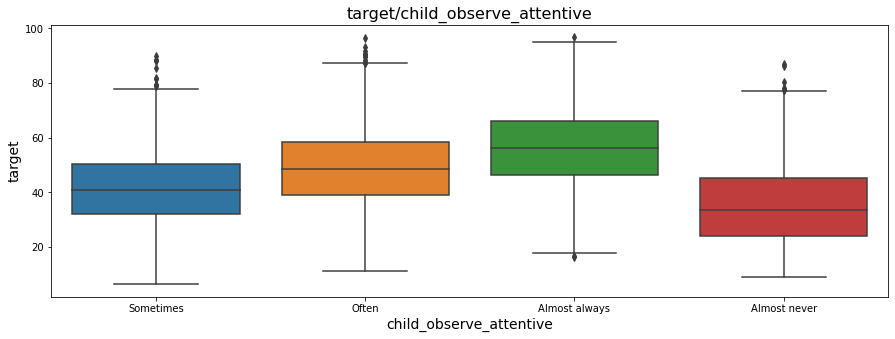

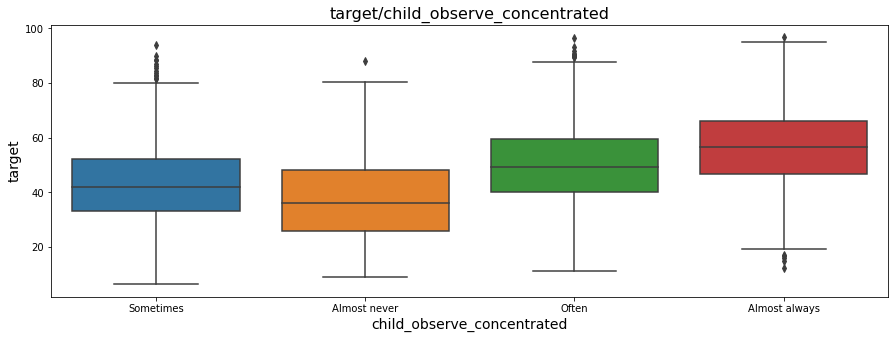

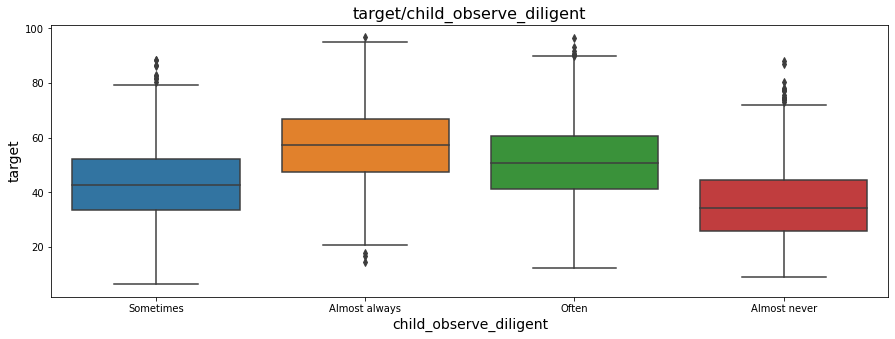

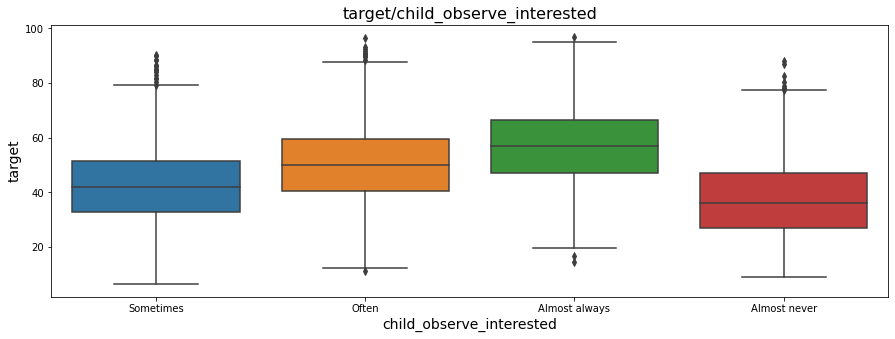

In [26]:
boxplot(observe_cols)

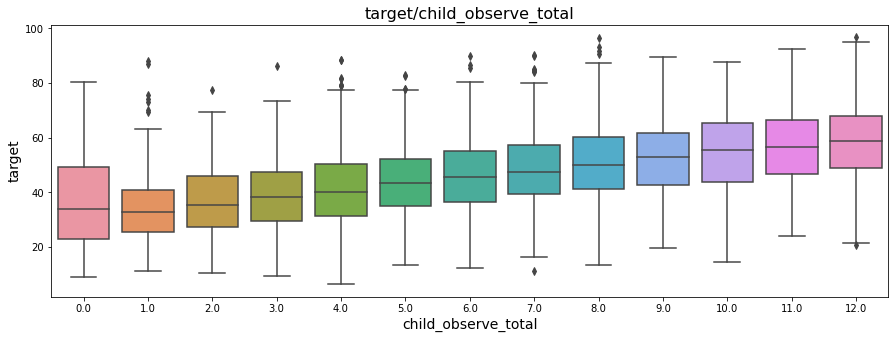

In [27]:
boxplot(["child_observe_total"])

Вывод: чем лучше оценка ребенка - тем выше таргет

In [28]:
map_rang(observe_cols, {
    'Almost never': 0,
    'Sometimes': 1, 
    'Often': 2,
    'Almost always': 3})

In [29]:
# Заполнить пропуски 
df_train['child_observe_total'] = df_train[observe_cols].sum(1)
df_test['child_observe_total'] = df_test[observe_cols].sum(1)

## Гипотеза 7

Чем выше оценка ребенка учителем - тем выше таргет

In [30]:
teacher_cols = [col for col in df_train.columns if 'teacher' in col]

In [31]:
df_train[teacher_cols].head()

,teacher_social_peers,teacher_social_nonaggressive,teacher_social_cooperate,teacher_social_assistance,teacher_social_ideas,teacher_social_initiative,teacher_emotional_understand,teacher_emotional_appropriate,teacher_emotional_independent,teacher_emotional_adjust,teacher_emotional_confidence,teacher_emotional_selfstarter,teacher_duration,teacher_social_total,teacher_selfcare_total,teacher_social_met,teacher_emotional_total,teacher_emotional_met,teacher_selfcare_met
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,Does not meet standard,NaN,Does not meet standard,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,4.0,Does not meet standard,7.0,Does not meet standard,Meets the standard
2,Most of the time,All of the time,All of the time,None of the time,A little of the time,None of the time,Often True,Not True,Sometimes True,Often True,Often True,Often True,NaN,15.0,4.0,NaN,9.0,NaN,Meets the standard
3,Most of the time,A little of the time,All of the time,All of the time,A little of the time,Most of the time,Often True,Often True,Often True,Often True,Often True,Often True,NaN,18.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard
4,All of the time,All of the time,All of the time,All of the time,All of the time,All of the time,Often True,Often True,Often True,Often True,Often True,Often True,NaN,24.0,4.0,Meets the standard,12.0,Meets the standard,Meets the standard


In [32]:
teacher_social_cols = [col for col in df_train.columns if 'teacher_social' in col]
teacher_social_cols.remove('teacher_social_met')

teacher_emotional_cols = [col for col in df_train.columns if 'teacher_emotional' in col]
teacher_emotional_cols.remove('teacher_emotional_met')

teacher_cols = teacher_social_cols + teacher_emotional_cols

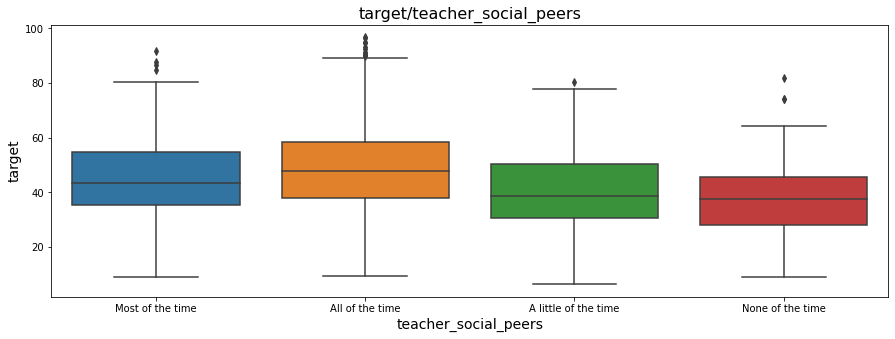

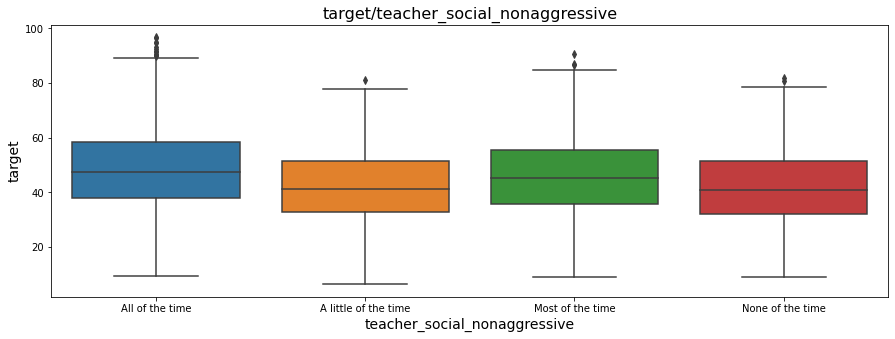

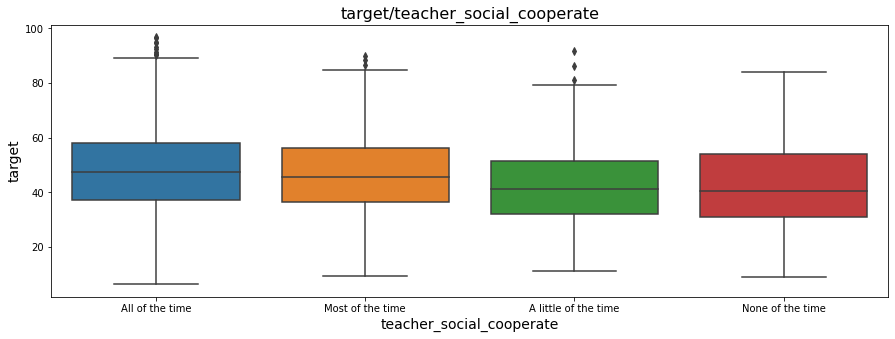

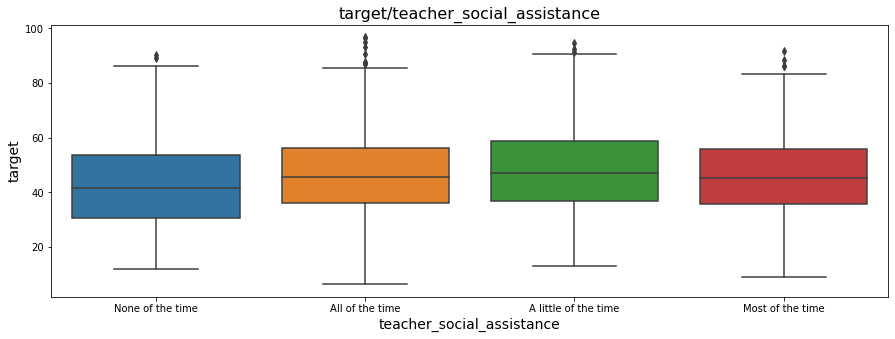

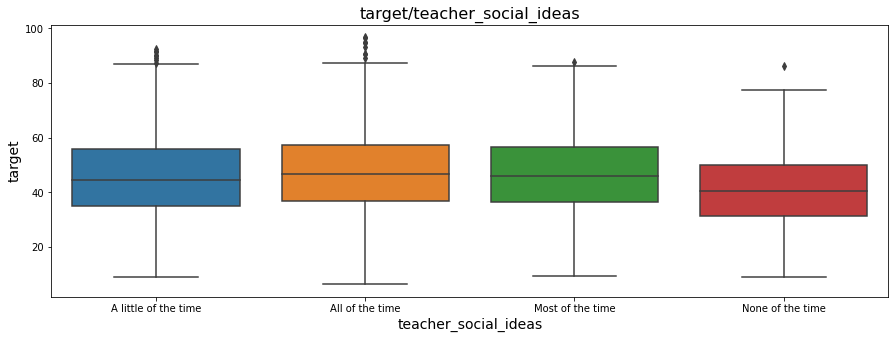

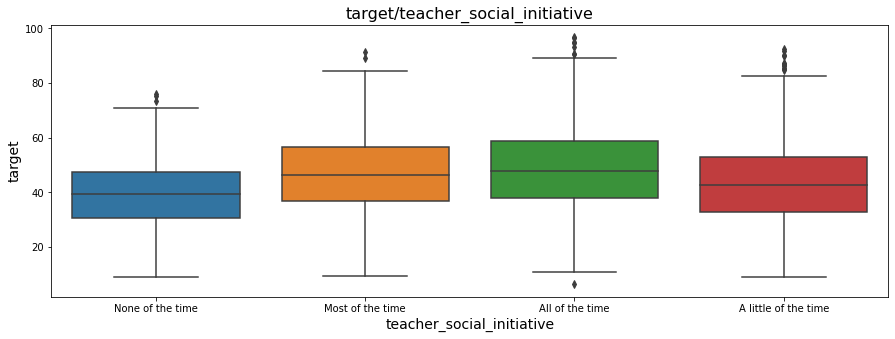

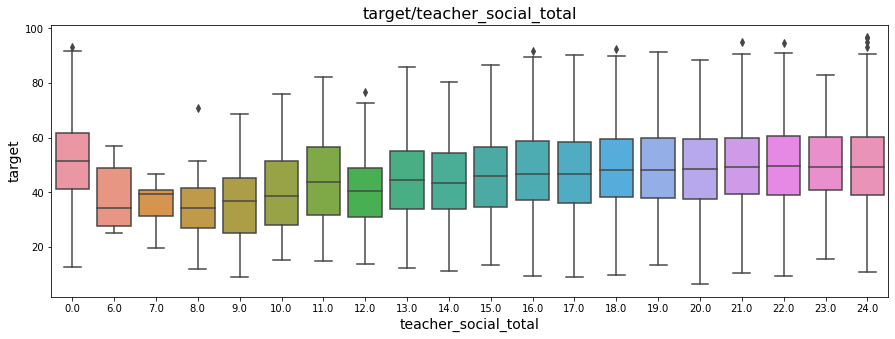

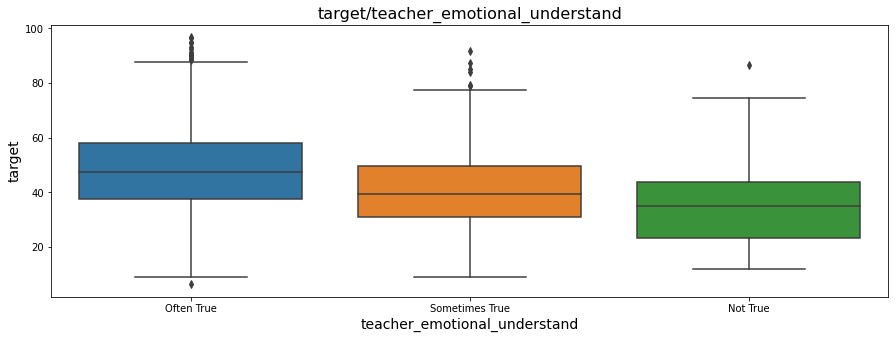

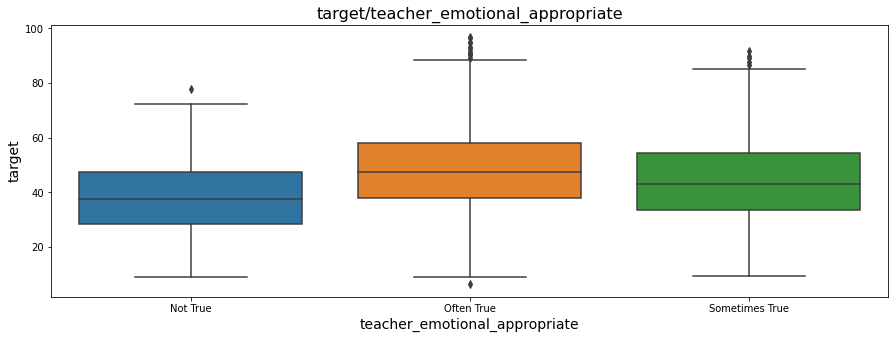

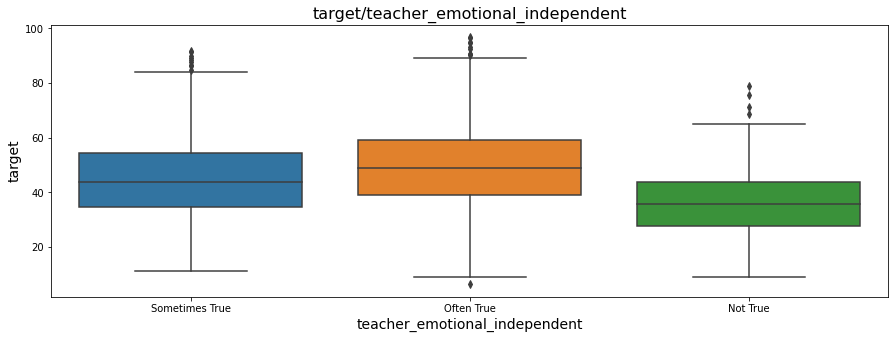

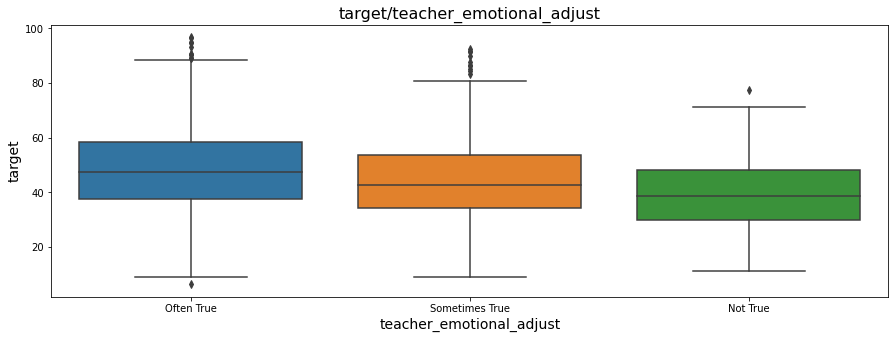

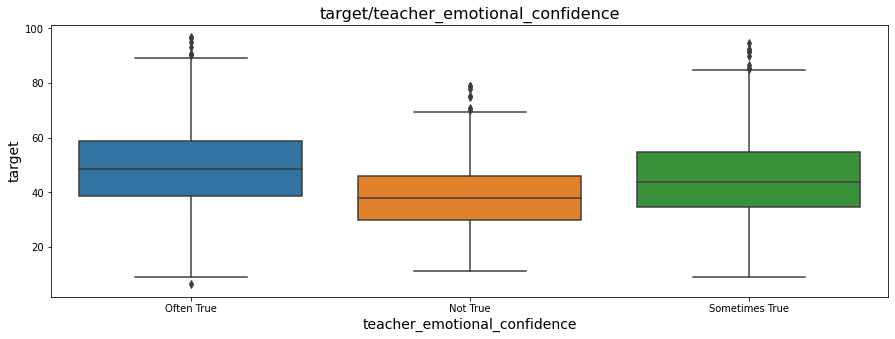

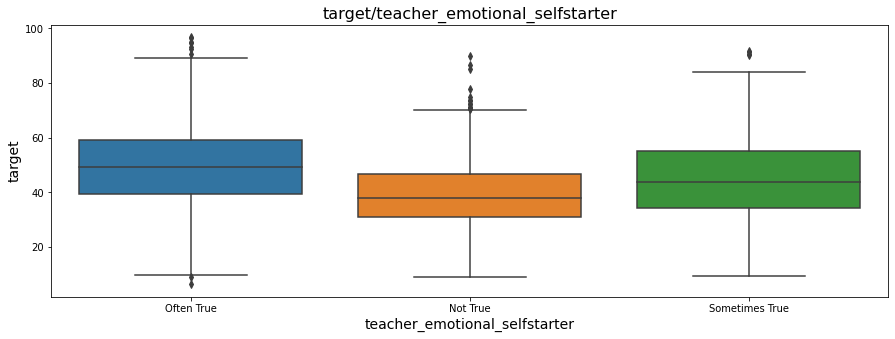

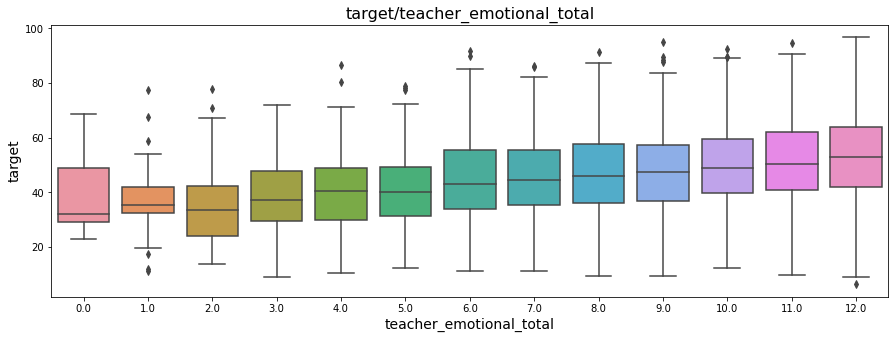

In [33]:
boxplot(teacher_cols)

Во всех случаях таргет выше при лучшей оценке

In [34]:
map_rang(teacher_social_cols,{
    'All of the time':3,
    'Most of the time':2,
    'A little of the time':1,
    'None of the time':0})

map_rang(teacher_emotional_cols,{
    'Often True':2,
    'Sometimes True':1,
    'Not True':0
})

In [35]:
# итоговая оценка = сумме баллов

df_train['teacher_social_total'] = df_train[teacher_social_cols].sum(1)
df_test['teacher_social_total'] = df_train[teacher_social_cols].sum(1)

df_train['teacher_emotional_total'] = df_train[teacher_emotional_cols].sum(1)
df_test['teacher_emotional_total'] = df_train[teacher_emotional_cols].sum(1)

## Гипотеза 8

Дети, семьи которых получают за них пособье имеют более высокий таргет

In [36]:
df_train["child_grant"].describe()

count     5452
unique       4
top        Yes
freq      4515
Name: child_grant, dtype: object

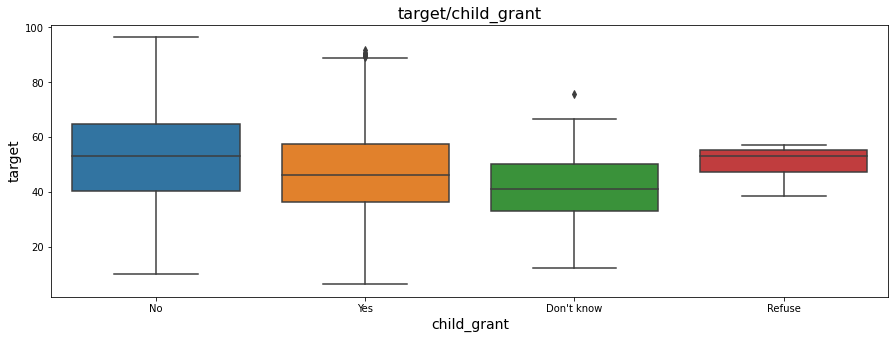

In [37]:
boxplot(['child_grant'])

Вывод: у детей без гранта таргет выше, наиболее низкий таргет у детей с ответом "не знаю"

## Гипотеза 9

Чем лучше посещаемость ребенка - тем выше таргет

In [38]:
df_train["pri_attendance"].describe()

count                  2686
unique                    5
top       Five times a week
freq                   2167
Name: pri_attendance, dtype: object

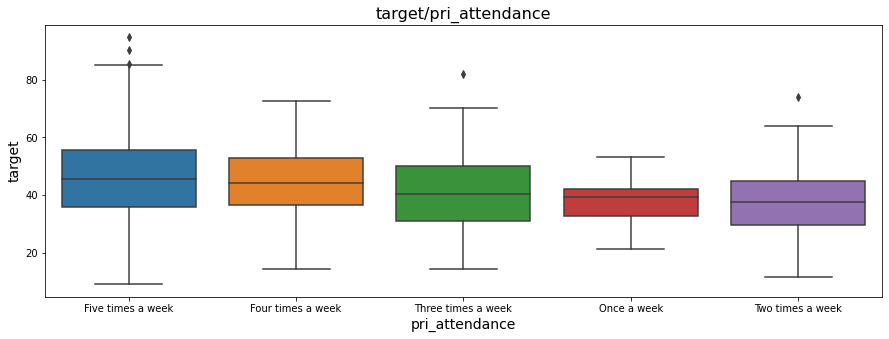

In [39]:
boxplot(["pri_attendance"])

Вывод: гипотеза подтвердилась

In [40]:
map_rang(['pri_attendance'], {
    'Five times a week':5,
    'Four times a week':4,
    'Three times a week':3,
    'Two times a week':2,
    'Once a week':1})

## Гипотеза 11

Чем лучше состояние оборудования в школе - тем выше таргет ребенка

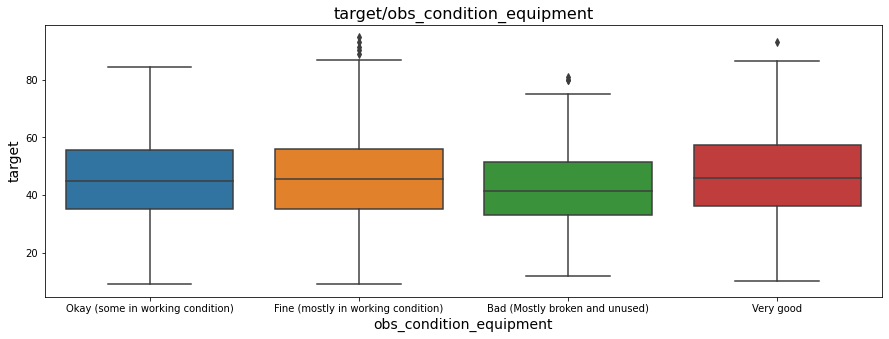

In [41]:
boxplot(['obs_condition_equipment'])

Вывод: гипотеза подтвердилась

In [42]:
map_rang(['obs_condition_equipment'], {
    'Very good': 3,
    'Fine (mostly in working condition)':2,
    'Okay (some in working condition)': 1,
    'Bad (Mostly broken and unused)': 0})

## Гипотеза 12

Чем больше даётся ребенку времени для игр, тем выше будет таргет

In [43]:
df_train[['pra_free_play','pra_free_play_outdoor']].head()

,pra_free_play,pra_free_play_outdoor
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,Up to 1 hour,Up to 1 hour
4,30 minutes or less,30 minutes or less


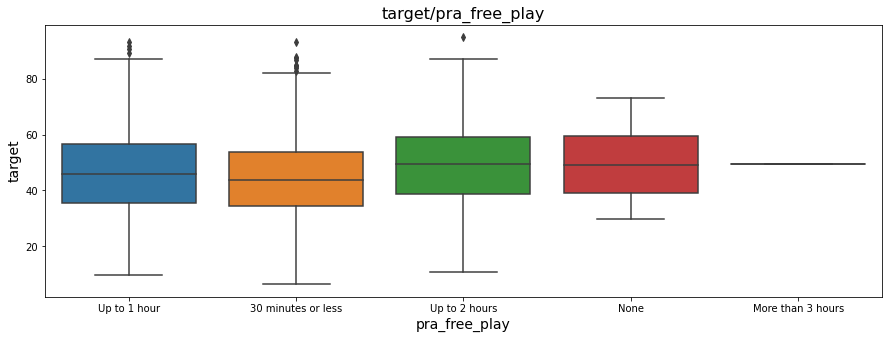

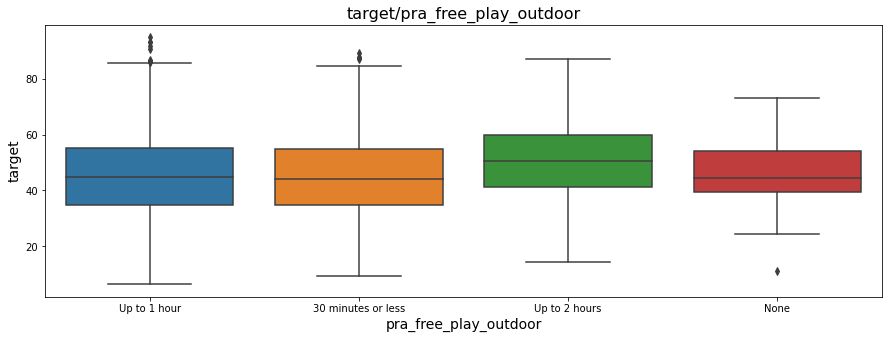

In [44]:
boxplot(['pra_free_play', 'pra_free_play_outdoor'])

Вывод: гипотеза подтвердилась

In [45]:
map_rang(['pra_free_play','pra_free_play_outdoor'], {
    'More than 3 hours':180,
    'Up to 2 hours':120,
    'Up to 1 hour':60,
    '30 minutes or less':30,
    'None':0,
})

## Гипотеза 13

Чем выше вовлеченность преподавателей в обучение в игровой форме - тем выше таргет ребенка

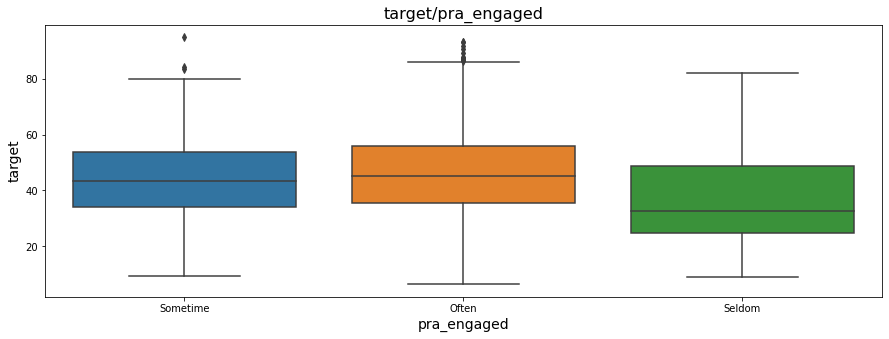

In [46]:
boxplot(['pra_engaged'])

Вывод: гипотеза подтвердилась

In [47]:
map_rang(['pra_engaged'], {
    'Often': 2,
    'Sometime': 1,
    'Seldom': 0
})

## Гипотеза 14

Чем выше уровень гигиены в школе - тем выше таргет ребенка

In [48]:
# удаляем неинформативные колонки, проще брать информацию из общей, а не из бинов
drop_cols += ["obs_handwashing_1", "obs_handwashing_2", "obs_handwashing_3",
           "obs_handwashing_0", "obs_handwashing_97", "obs_toilet_1",
           "obs_toilet_2", "obs_toilet_3", "obs_toilet_4", "obs_toilet_5",
           "obs_toilet_6", "obs_toilet_7", "obs_toilet_8", "obs_toilet_0",
           "obs_toilet_97"]

In [49]:
def obs_toilet_rang(obs_toilet:str) -> str:
    obs_toilet = str(obs_toilet)
    if '0' in obs_toilet:
        return 0
    elif '1' in obs_toilet or '2' in obs_toilet or '8' in obs_toilet:
        return 3
    elif '3' in obs_toilet or '4' in obs_toilet or '5' in obs_toilet:
        return 2
    elif '6' in obs_toilet or '7' in obs_toilet:
        return 1

ранговая система 0-нет туалета 1-горшки ведра, 2-выгребные ямы, 3-норм тулеты

In [50]:
df_train['toilet_rang'] = df_train.apply(lambda x: obs_toilet_rang(x['obs_toilet']),axis=1)
df_test['toilet_rang'] = df_test.apply(lambda x: obs_toilet_rang(x['obs_toilet']),axis=1)

In [51]:
def obs_handwashing_rang(obs_handwashing:str) -> str:
    obs_handwashing = str(obs_handwashing)
    if '0' in obs_handwashing:
        return 0
    elif '1' in obs_handwashing or '2' in obs_handwashing:
        return 3
    elif '97' in obs_handwashing:
        return 2
    elif '3' in obs_handwashing:
        return 1

ранговая система где 0 - нет мытья рук. 3 - есть кран, 2 - другое, 1 - ведро

In [52]:
df_train['handwashing_rang'] = df_train.apply(lambda x: obs_handwashing_rang(x['obs_handwashing']),axis=1)
df_test['handwashing_rang'] = df_test.apply(lambda x: obs_handwashing_rang(x['obs_handwashing']),axis=1)

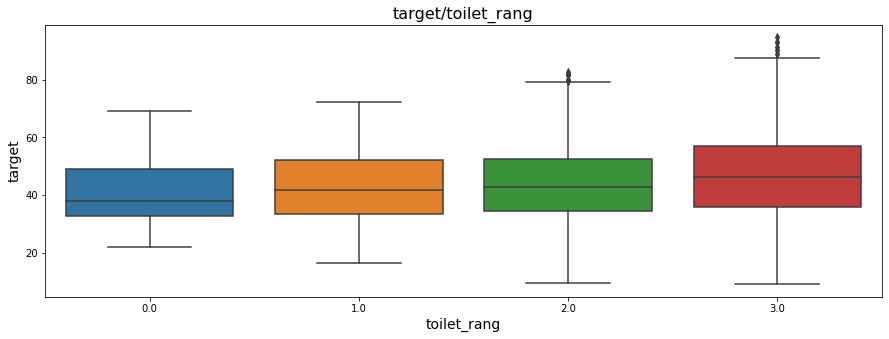

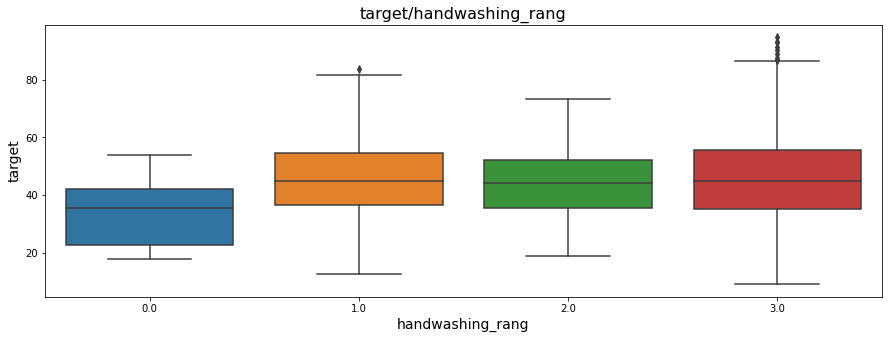

In [53]:
boxplot(['toilet_rang', 'handwashing_rang'])

Вывод: гипотеза подтвердилась, у детей без гигиены в школах заметно ниже таргет. Улучшение средств гигиенты слегка увеличивает таргет

## Гипотеза 15

Чем лучше разделены дети в классе по возрасту - тем выше таргет ребенка

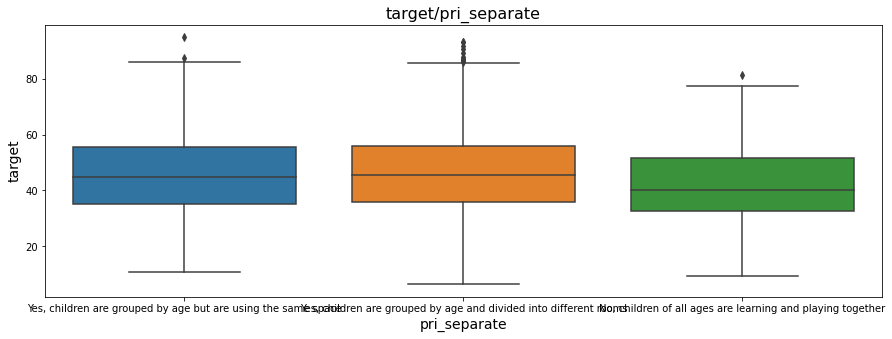

In [54]:
boxplot(['pri_separate'])

Вывод: гипотеза подтвердилась, у детей учащихся в классе с разницей в возрасте таргет заметно ниже

In [55]:
map_rang(['pri_separate'], {
        'Yes, children are grouped by age and divided into different rooms':2,
        'Yes, children are grouped by age but are using the same space':1,
        'No, children of all ages are learning and playing together':0})

## Гипотеза 17

У детей, учащихся в школах, имеющих более качественное здание - выше таргет

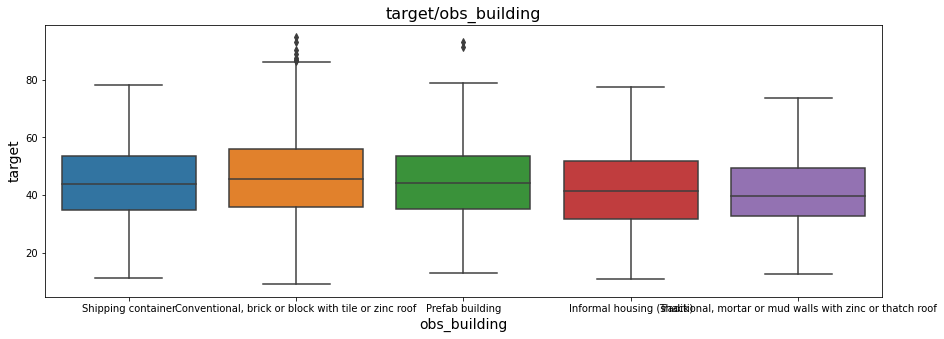

In [56]:
boxplot(["obs_building"])

Вывод: гипотеза подтвердилась, самый высокий таргет в школах из кирпича, самый низкий - в традиционных зданиях из строительного раствора с соломенной крышей

In [57]:
map_rang(['obs_building'], {
    'Conventional, brick or block with tile or zinc roof':4,
    'Prefab building':3,
    'Shipping container':2,
    'Informal housing (shack)':1,
    'Traditional, mortar or mud walls with zinc or thatch roof':0})

## Гипотеза 18

Чем больше квантиль и ses (ранговые спутниковые данные), тем выше таргет

In [58]:
df_train[['ses_cat', 'ses_proxy', 'quintile']].head()

,ses_cat,ses_proxy,quintile
0,NaN,2.0,2.0
1,NaN,4.0,4.0
2,R0-110,1.0,4.0
3,R291-750,3.0,1.0
4,R0-110,1.0,1.0


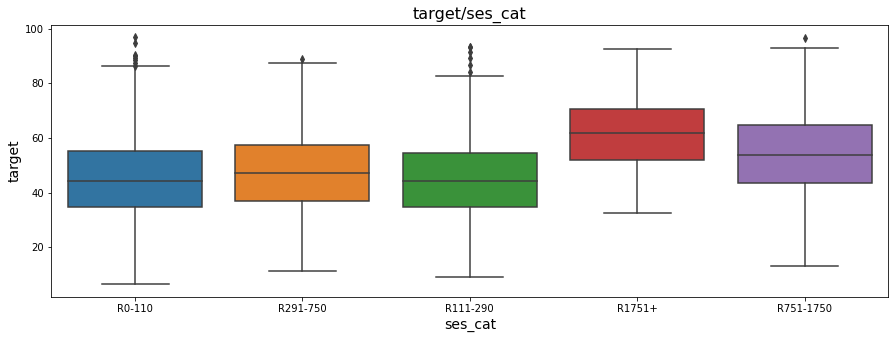

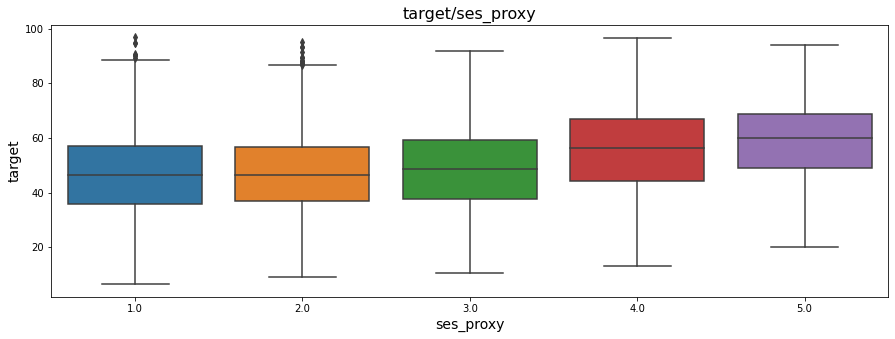

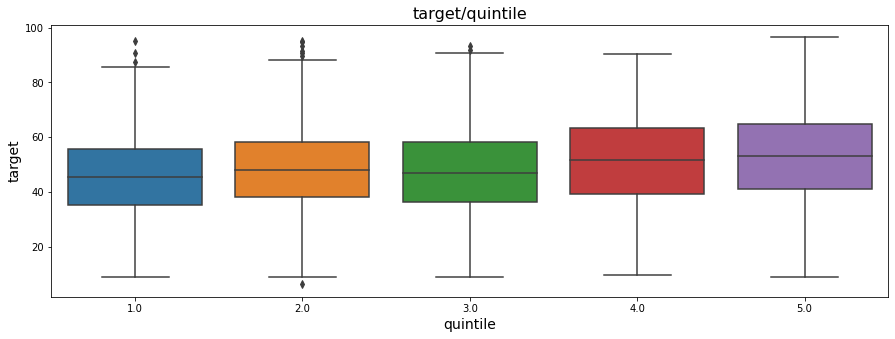

In [59]:
boxplot(['ses_cat', 'ses_proxy', 'quintile'])

Вывод: гипотеза подтвердилась. ses_proxy - ранговое выражение ses_cat, но пропуски там заполнены quintile, стоит удалить чтобы не было корреляции

In [60]:
drop_cols += ["ses_proxy"]

In [61]:
map_rang(['ses_cat'], {
    'R0-110':0,
    'R111-290':1,
    'R291-750':2,
    'R751-1750':3,
    'R1751+':4})

## Гипотеза 19

Язык ребенка влияет на таргет. Таргет будет выше у английского языка

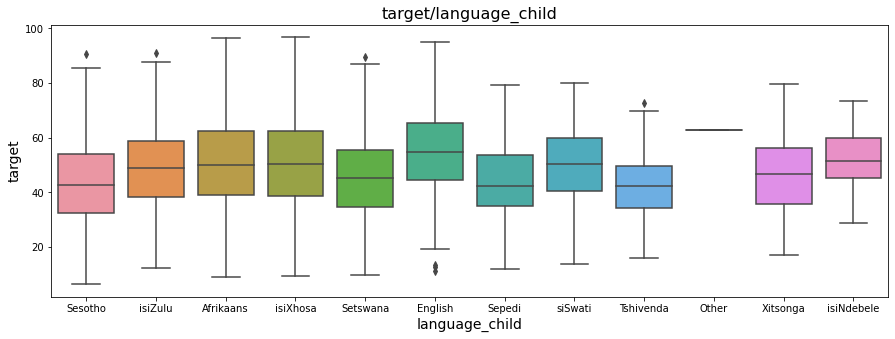

In [62]:
boxplot(['language_child'])

Вывод: язык влияет на таргет. Наиболее высокий - у английского, низкий - у Sesotho, Setswana, Sepedi и Tshivenda языков

In [63]:
df_train[['language_child', 'language_assessment', 'language_match']].describe(include='all')

,language_child,language_assessment,language_match
count,7042,8585,8523.000000
unique,12,13,NaN
top,isiZulu,isiZulu,NaN
freq,1387,1665,NaN
mean,NaN,NaN,0.999296
std,NaN,NaN,0.026525
min,NaN,NaN,0.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,1.000000


In [64]:
df_train['language_match'].value_counts()

1.0    8517
0.0       6
Name: language_match, dtype: int64

In [65]:
# стоит удалить чтобы не было кореляции, тк всего 6 значений из всего датасета не совпадают
drop_cols += ['language_match', 'language_assessment']

## Гипотеза 20

Таргет будет различным для детей из разных регионов. У детей из редких регионов таргет будет ниже

In [66]:
df_train[[ "id_prov", "id_dc_best"]].describe()

,id_prov,id_dc_best
count,6901,6746
unique,9,50
top,WC,CPT
freq,1634,895


In [67]:
def is_dc_rare(dc:str, df) -> str:
    if dc not in df.id_dc_best.value_counts()[:23]:
        dc = 'Rare'
    return dc

df_train['id_dc_best'] = df_train['id_dc_best'].fillna("No_info")
df_train['id_dc_best'] = df_train.apply(lambda x: is_dc_rare(x['id_dc_best'], df=df_train), axis=1)

df_test['id_dc_best'] = df_test['id_dc_best'].fillna("No_info")
df_test['id_dc_best'] = df_test.apply(lambda x: is_dc_rare(x['id_dc_best'], df=df_test), axis=1)

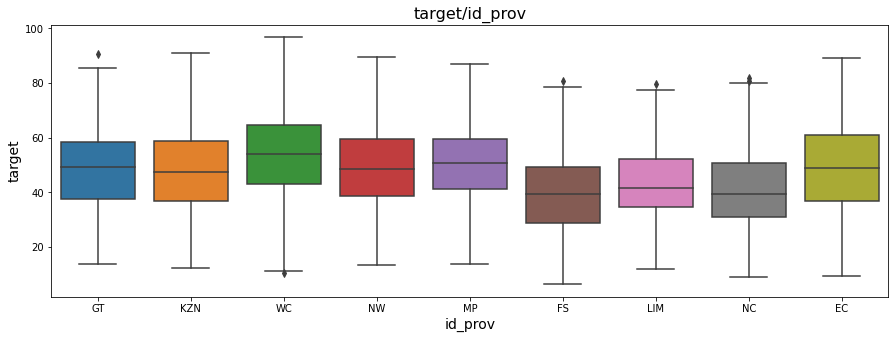

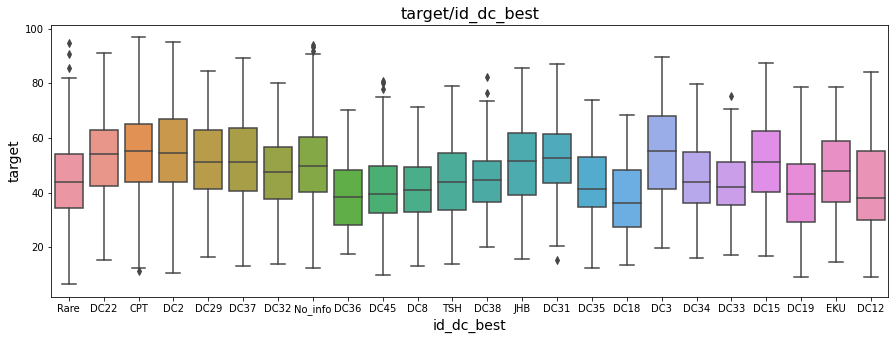

In [68]:
boxplot(["id_prov", "id_dc_best"])

Вывод: таргет разный в регионах, таргет у редких регионов ниже среднего

In [69]:
# переименовываю чтобы в дальнейшем удалить колонки с id
df_train = df_train.rename(columns={"id_prov": "prov", "id_dc_best": "dc"})
df_test = df_test.rename(columns={"id_prov": "prov", "id_dc_best": "dc"})

# Заполнение пропусков

In [70]:
df_train.shape

(8585, 684)

In [71]:
cat_cols = []

for col in df_train.drop(columns=['target']).columns: 
    
    if df_train[col].dtype in ['int64', 'int32', 'float64']:

        df_train[col] = df_train[col].fillna(-99)
        df_test[col] = df_test[col].fillna(-99)
        
    elif df_train[col].dtype in ['O', object, 'bool']:
        
        if df_train[col].nunique() > 25 or df_train[col].nunique() == 1:
            # удаляю столбцы где только 1 уникальное значение или их больше 25
            drop_cols.append(col)
        elif df_train[col].nunique() == 2:
            # если 2 уникальных значения и второе встречается редко - тоже удалить стоит 
            if min(df_train[col].value_counts()) < 160: 
                drop_cols.append(col)
            else:
                # если 2 уникальных значения выражаем их 0 и 1, пропуски заполняем -99
                df_train[col] = (df_train[col].dropna() == df_train[col].dropna().unique()[0]).astype(int)
                df_train[col] = df_train[col].fillna(-99)
                
                df_test[col] = (df_test[col].dropna() == df_test[col].dropna().unique()[0]).astype(int)
                df_test[col] = df_test[col].fillna(-99)
        else:
            df_train[col] = df_train[col].fillna("No_info")
            df_test[col] = df_test[col].fillna("No_info")
            cat_cols.append(col)

In [72]:
bin_cols = [col for col in df_train.columns if '_1' == col[-2:]]

for col in bin_cols:
    if col[:-2] in df_train.columns:
        drop_cols.append(col[:-2])

In [73]:
# удаление всех id
id_cols = [col for col in df_train.columns if 'id' == col[:2]]
id_cols.append("child_id")

# удаление лучших мест
best_cols = [col for col in df_train.columns if 'best' in col]
# удаление ответов другое в бинаризованных вариантах
othet_cols = [col for col in df_train.columns if 'other' in col]

cols_to_drop = id_cols + best_cols + othet_cols

drop_cols += [col for col in cols_to_drop if col not in drop_cols]

In [74]:
df_train = df_train.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [75]:
cat_cols = [x for x in cat_cols if x not in drop_cols]

In [76]:
df_train.shape, df_test.shape

((8585, 220), (3680, 219))

Проверка заполненности пропусков

In [77]:
df_train.isna().sum().max()

0

# Сохранение df и cat_cols для дальнейшего использования

In [78]:
import pickle

with open('cat_cols.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

In [79]:
df_train.to_csv("df_train_preprod.csv", index=False) 
df_test.to_csv("df_test_preprod.csv", index=False) 